<a href="https://colab.research.google.com/github/AlinaZakharova1997/hse_tasks/blob/master/WSD_WSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Sense Disambiguation (снятие лексической неоднозначности) и Word Sense Induction (нахождение значений слова)

WSD и WSI  - это связанные задачи про определение значений, в которых употребляются слова. WSI занимается определением возможных значений слова, а WSD нужна для того, чтобы определить, в каком из имеющихся значений слово употреблено в тексте. 

На прошлых занятиях мы вообще закрывали глаза на то, что у слов может быть несколько значений, т.к. в целом это не такая уж серьезная проблема. Однако в некоторых практических задачах учёт многозначности может сильно помочь (например, в поиске результат будет отличаться для запросов "гоголь фильм" и "гоголь писатель")

Основное предположение, на котором строятся все модели для снятия и определения неоднозначности - значение определяется в контексте (отличие от эмбедингов в том, что тут имеется в виду конкретный контекст и конкретное значение, а не набор всех контекстов и общее значение=смысл слова). Т.к контекст может включать в себя невероятного много всего (от 1 соседнего слова до актуальных мемов), решить задачу полностью пока нельзя и это, наверное, сложная и интересная тема для исследований. Про sota в этой области можно почитать вот тут - http://nlpprogress.com/english/word_sense_disambiguation.html  
Но в рамках семинара давайте посмотрим, какие есть уже готовые инструменты или простые алгоритмы для работы с многозначностью.

А сейчас попробуем Адаграм!

In [ ]:
import adagram
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os, re, sys
from collections import Counter
import numpy as np
from razdel import tokenize as razdel_tokenize
from matplotlib import pyplot as plt
import gensim
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import tqdm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [token.text.strip(punct) for token in list(razdel_tokenize(text))]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip3 install razdel

In [ ]:
!pip3 install pymorphy2

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 8.2MB 9.9MB/s 


## Адаграм

Word2Vec и Fasttext каждому слову (или буквенному нграму) сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. 

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопостовлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова (т.е. делает WSI).

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

In [ ]:
!pip3 install Cython numpy
!pip3 install git+https://github.com/lopuhin/python-adagram.git

  Cloning https://github.com/lopuhin/python-adagram.git to /tmp/pip-req-build-a052igri
  Running command git clone -q https://github.com/lopuhin/python-adagram.git /tmp/pip-req-build-a052igri
  Created wheel for adagram: filename=adagram-0.0.1-cp37-cp37m-linux_x86_64.whl size=455347 sha256=53498aba741aec79d0149a81e655db8b0fbb2ee5f530325c8bf546155d459bc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-rbg7fvc4/wheels/11/0f/46/f5df96670df8f7973b4c2311ffc9b02e435a7bd3207f992c4d
Successfully built adagram


Обучается адаграм через командную строку.

Возьмем небольшой новостной корпус. Нормализуем.

In [ ]:
corpus = open('wiki_data.txt').read()
corpus = normalize(corpus)

In [ ]:
corpus[:10]

['новостройка',
 'нижегородский',
 'область',
 'новостро́йка',
 'сельский',
 'посёлок',
 'дивеевский',
 'район',
 'нижегородский',
 'область']

И положим одним куском в файл.

In [ ]:
f = open('corpus.txt', 'w')
f.write(' '.join(corpus))
f.close()

Обучим модель (обучается достаточно долго)

In [ ]:
!adagram-train corpus.txt out.pkl

[INFO] 2021-03-14 09:59:29,236 Building dictionary...
[INFO] 2021-03-14 09:59:33,269 Done! 6270 words.
[INFO] 2021-03-14 09:59:44,948 18.82% -7.3442 0.0203 1.5/3.0 5.58 kwords/sec
[INFO] 2021-03-14 09:59:52,537 37.65% -7.1695 0.0156 1.6/4.0 8.43 kwords/sec
[INFO] 2021-03-14 10:00:00,158 56.47% -7.0563 0.0109 1.7/4.0 8.40 kwords/sec
[INFO] 2021-03-14 10:00:07,707 75.29% -6.9780 0.0062 1.7/4.0 8.48 kwords/sec
[INFO] 2021-03-14 10:00:15,231 94.11% -6.9251 0.0015 1.7/4.0 8.51 kwords/sec
[INFO] 2021-03-14 10:00:17,557 100.00% -6.8986 0.0000 1.8/4.0 8.61 kwords/sec


Обученная модель загружается вот так.

In [ ]:
vm = adagram.VectorModel.load("out.pkl")

In [ ]:
# модель обученная на большом корпусе (острожно 1.5 гб)
!wget 'https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib'
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

--2021-03-14 10:00:24--  https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.226.83
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.226.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1462416741 (1.4G) [application/x-www-form-urlencoded]
Saving to: ‘all.a010.p10.d300.w5.m100.nonorm.slim.joblib’

all.a010.p10.d300.w 100%[===================>]   1.36G  47.5MB/s    in 30s     

2021-03-14 10:00:54 (46.5 MB/s) - ‘all.a010.p10.d300.w5.m100.nonorm.slim.joblib’ saved [1462416741/1462416741]



Посмотрим на значения каких-нибудь слова.

In [ ]:
vm.word_sense_probs('мир')
# возвращается список туплов, где первая цифра - номер значения, а вторая - вероятность (распространенность) этого значения

[(0, 0.06268646203840206),
 (1, 0.20436841565195035),
 (2, 0.28245536273741867),
 (3, 0.4499986631679041)]

Посмотрим какие слова близки к каждому из значений.

In [ ]:
vm.sense_neighbors('мир', 0) # первое значение слова мир

[('европа', 0, 0.86309934),
 ('азия', 0, 0.7843011),
 ('юниор', 0, 0.75505394),
 ('россия', 3, 0.7537),
 ('призерка', 0, 0.74310327),
 ('юниорский', 0, 0.72926927),
 ('победитель', 0, 0.72810775),
 ('командный', 0, 0.72130823),
 ('победительница', 0, 0.7165183),
 ('среди', 4, 0.7144474)]

In [ ]:
vm.sense_neighbors('мир', 2) # второе

[('реальность', 1, 0.73328036),
 ('космос', 2, 0.7112729),
 ('действительность', 2, 0.7024969),
 ('восприятие', 1, 0.6677514),
 ('единство', 0, 0.6616055),
 ('универсум', 0, 0.65104866),
 ('природа', 0, 0.6396403),
 ('жизнь', 3, 0.6382615),
 ('бытие', 1, 0.6363366),
 ('ноуменальный', 0, 0.6316216)]

Чтобы не гадать, можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [ ]:
ambiguous = []
for word in vm.dictionary.id2word:
    if len(word) < 5:
        continue
    probs = vm.word_sense_probs(word)
    if len(probs) > 1 and probs[0][1] < 0.8: # второе условие нужно, чтоб выкинуть слова с не очень сильным вторым значением
        ambiguous.append(word)

In [ ]:
ambiguous[:30]

['который',
 'человек',
 'такой',
 'только',
 'время',
 'когда',
 'другой',
 'становиться',
 'сказать',
 'чтобы',
 'самый',
 'знать',
 'первый',
 'говорить',
 'очень',
 'жизнь',
 'после',
 'много',
 'можно',
 'новый',
 'место',
 'работа',
 'иметь',
 'хотеть',
 'давать',
 'большой',
 'какой',
 'каждый',
 'понимать',
 'просто']

Определить значение по контексту можно вот так:

In [ ]:
vm.disambiguate("мир", ['реальность', "космос"]) # выдает вероятности

array([2.14328321e-05, 1.11974936e-02, 8.70955617e-01, 1.17825457e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [ ]:
# достаем номер самого вероятного значения
vm.disambiguate("мир", ['реальность', "космос"]).argmax()

2

А вектор нужно смысла можно достать вот так:

In [ ]:
v = vm.sense_vector("мир", 0)

In [ ]:
v

array([ 4.37387705e-01, -4.17701691e-01, -1.68972075e-01, -1.31608978e-01,
       -3.58765095e-01, -2.69918740e-01,  8.17285478e-02, -2.88361549e-01,
       -7.78897524e-01, -1.07620642e-01,  4.13761586e-01,  2.00120255e-01,
       -2.17124864e-01,  1.69630170e-01, -6.04783855e-02, -2.85457760e-01,
        2.45123908e-01, -2.58435696e-01, -2.93894112e-01,  3.84041101e-01,
       -1.48722053e-01, -3.67544800e-01,  4.83283289e-02, -1.93067133e-01,
        1.07686751e-01,  4.84683551e-02,  2.33559936e-01,  2.47575402e-01,
        1.77351832e-01,  5.35611570e-01, -9.10755098e-02,  7.43860304e-01,
       -4.04182345e-01,  4.39577013e-01,  1.00546956e-01,  2.84698576e-01,
        6.52314723e-02,  2.96857178e-01,  2.65073836e-01, -2.53373921e-01,
       -4.76764947e-01,  1.24576494e-01,  2.38348663e-01, -2.84977645e-01,
       -2.37765592e-02,  1.86345071e-01,  4.95471507e-02, -9.81912091e-02,
       -3.34809333e-01, -2.25521475e-01, -7.94327259e-02, -2.49491557e-01,
        4.76329505e-01,  

Как и с другими векторными моделями, проверять Адаграм нужно на реальной задаче.

### Адаграм в определении перефразирования

In [ ]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [ ]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

Векторизуем пары текстов с помощью Адаграма, обучим какую-нибудь модель и оценим качество (также как делали на семинаре по обычным эмбедингам). 


Для того, чтобы сопоставить слову нужный вектор нужно вытащить и его контекст слева и справа. 

In [ ]:
def get_embedding_adagram(text, model, window, dim):
    
    
    word2context = []
    for i in range(len(text)-1):
        left = max(0, i-window)
        word = text[i]
        left_context = text[left:i]
        right_context = text[i+1:i+window]
        context = left_context + right_context
        word2context.append((word, context))
    
    
    
    vectors = np.zeros((len(word2context), dim))
    
    for i,word in enumerate(word2context):
        word, context = word
        try:
            sense = model.disambiguate(word, context).argmax()
            v = model.sense_vector(word, sense)
            vectors[i] = v # просто умножаем вектор на частоту

        except (KeyError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [ ]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [ ]:
data['text_1_norm']

0       [полицейский, разрешить, стрелять, поражение, ...
1       [право, полицейский, проникновение, жилища, ре...
2       [президент, египет, ввести, чрезвычайный, поло...
3       [вернуться, сирия, россиянин, волновать, вопро...
4       [в, москва, сирия, вернуться, 2, самолёт, мчс,...
                              ...                        
7222       [путин, освободить, должность, ряд, генералов]
7223    [облако, москва, день, победа, разогнать, девя...
7224    [люблян, отпраздновать, день, победа, вместе, ...
7225    [девять, самолёт, ввс, разогнать, облако, моск...
7226    [9, май, метрополитен, петербург, работать, кр...
Name: text_1_norm, Length: 7227, dtype: object

Сделаем все точно также как и на прошлом семинаре.

In [ ]:
dim = 300
X_text_1 = np.zeros((len(data['text_1_norm']), dim))
X_text_2 = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1[i] = get_embedding_adagram(text, vm, 5, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2[i] = get_embedding_adagram(text, vm, 5, dim)

In [ ]:
X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [ ]:
y = data['label'].values

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y,random_state=1)
clf = RandomForestClassifier(n_estimators=200,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.60      0.51      0.55       629
          0       0.47      0.77      0.59       737
          1       0.43      0.06      0.10       441

avg / total       0.51      0.51      0.46      1807



In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1, )
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.47      0.50      0.48       629
          0       0.46      0.59      0.51       737
          1       0.30      0.14      0.19       441

avg / total       0.42      0.45      0.42      1807



Сделаем ещё нормальную валидацию.

In [ ]:
kf = KFold(n_splits=5)
f1_scores = []
for train_index, test_index in kf.split(X_text):
    
    X_train, X_test = X_text[train_index], X_text[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(n_estimators=200,
                             class_weight='balanced')
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    f1_scores.append(f1_score(y_test, preds, average='micro'))
    
print(np.mean(f1_scores))

0.4740557174785951


### WSI

WSI можно представить как задачу кластеризации контекстов, в которых встречается слово 

Возьмем данные диалоговского соревнования 2018 года - https://github.com/nlpub/russe-wsi-kit/blob/master/data/main/wiki-wiki/train.csv (только train часть для простоты)

В данных примеры использования целевых слов и индексы значений, которые могут быть у этого слова.

В качестве метрики используется Adjuster Rand Index. https://en.wikipedia.org/wiki/Rand_index , http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

Эта метрика похожа на accuracy, она нужна когда у нас нет единого стандарта описания лейблов. В этой задаче у нас есть индексы значений в золотом стандарте и номера кластеров, которые мы получим в своем решении. Мы не можем сравнить их напрямую (кластер 1 и индекс 1 не означает, что мы сделали правильное предсказание). Нам важно, чтобы к одному и тому же кластеру/индексу относились одни и те же слова в контекстах, а слова с разными индексами имели и разные кластеры. ARI именно это и считает.

In [ ]:
df = pd.read_csv('train.csv', sep='\t')

In [ ]:
df.head(20)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
2,3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании м..."
4,5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...
5,6,замок,1,NaN,"42-47, 281-286",его без боя . в начале xviii века высокий замо...
6,7,замок,1,NaN,"260-265, 495-500",", колодец , хозяйственные помещения ( склады п..."
7,8,замок,1,NaN,"197-202, 205-210, 415-420",— сын гедимина трокский князь кейстут . около ...
8,9,замок,1,NaN,"28-33, 196-201, 257-262, 417-422",одним из кэмпбеллов — отдал замок в обмен на в...
9,10,замок,1,NaN,"0-5, 14-19, 175-180",замок сталкер замок был построен в г . и перв...


Попробуем решить эту задачу фастекстом.

Возьмем функцию для эмбединга предложений из прошлого семинара. (Вектора слов усредняются)

In [ ]:
def get_embedding(text, model, dim):
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [ ]:
corpus = [normalize(line) for line in open('wiki_data.txt')]

In [ ]:
# corpus = open('wiki_data.txt').read()

fast_text = gensim.models.FastText(corpus, size=200, max_vocab_size=100000)

Данные соревнования - не новостные тексты, поэтому можно обучить модель на чем-то другом. Тексты из википедии наверное подойдут.

С помощью функции groupby мы можем сделать словарь: слово, значения которого надо найти - всего его контексты и размеченные значения.

In [ ]:
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [ ]:

for key, _ in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

    word                                            context  gold_sense_id
383  бор  бор ( элемент ) бор — элемент тринадцатой груп...              1
384  бор  бор - углерод - кремний семейство сплавов на о...              1
385  бор  с большим выделением теплоты , образуется окси...              1
386  бор  это объясняется прежде всего тем , что у компл...              1
387  бор  совсем малочисленна . элементарный бор в приро...              1
388  бор  действующем при месторождении горно - химическ...              1
389  бор  b c ) . при нагревании в атмосфере кислорода и...              1
390  бор  собственных минералов бора в чужих минералах о...              1
391  бор  бор - углерод - кремний семейство сплавов на о...              1
392  бор  с другими галогенами с образованием тригалоген...              1
393  бор  и в стабильны и входят в состав природного бор...              1
394  бор  номером . обозначается символом b ( ) . в своб...              1
395  бор  и взаимные пере

По сути нам нужно кластеризовать контексты, в которых употреблено слово.

Попробуем разные методы кластеризации.

In [ ]:
from sklearn.cluster import *

In [ ]:
ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context'].apply(normalize)
    X = np.zeros((len(texts), 200))
    
    for i, text in enumerate(texts):
        text = [word for word in text if word != key]
        X[i] = get_embedding(text, fast_text, 200)
        
    cluster = AffinityPropagation(damping=0.5)
#     cluster = KMeans(3)
#     cluster = DBSCAN(min_samples=5, eps=0.1)
    cluster.fit(X)
    labels = np.array(cluster.labels_)+1
    
    ARI.append(adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
    
#     print(key, '  ', adjusted_rand_score(grouped_df.get_group(key)['gold_sense_id'], labels))
print(np.mean(ARI))

0.12527570377049024


## WordNet

Выводить значения просто из текста тяжело, поэтому можно попробовать воспользоваться словарями (wsi сделанное людьми). Для русского придется парсить сайты словарей, а для английского можно воспользоваться WordNet'ом (https://wordnet.princeton.edu/), который есть в nltk.

WordNet - это лексическая база данных, где существительные, прилагательные и глаголы английского сгруппированы по значению. К тому же между ними установлены связи (гипонимия, гипоронимия, миронимия и т.п.).

In [ ]:
# запустите если не установлен ворднет
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Группа синонимичных слов в WordNet'е называются синсеты. 

In [ ]:
# всего синсетов
len(list(wn.all_synsets()))

117659

Из них существительных:

In [ ]:
len(list(wn.all_synsets('n')))

82115

А глаголов:

In [ ]:
len(list(wn.all_synsets('v')))

13767

А прилагательных:

In [ ]:
len(list(wn.all_synsets('a')))

18156

Синсеты для слова можно достать вот так:

In [ ]:
wn.synsets('cat')

[Synset('cat.n.01'),
 Synset('guy.n.01'),
 Synset('cat.n.03'),
 Synset('kat.n.01'),
 Synset('cat-o'-nine-tails.n.01'),
 Synset('caterpillar.n.02'),
 Synset('big_cat.n.01'),
 Synset('computerized_tomography.n.01'),
 Synset('cat.v.01'),
 Synset('vomit.v.01')]

Можно ограничить часть речи:

In [ ]:
wn.synsets('go', pos='v')

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05'),
 Synset('run.v.05'),
 Synset('run.v.03'),
 Synset('proceed.v.04'),
 Synset('go.v.09'),
 Synset('go.v.10'),
 Synset('sound.v.02'),
 Synset('function.v.01'),
 Synset('run_low.v.01'),
 Synset('move.v.13'),
 Synset('survive.v.01'),
 Synset('go.v.16'),
 Synset('die.v.01'),
 Synset('belong.v.03'),
 Synset('go.v.19'),
 Synset('start.v.09'),
 Synset('move.v.15'),
 Synset('go.v.22'),
 Synset('go.v.23'),
 Synset('blend.v.02'),
 Synset('go.v.25'),
 Synset('fit.v.02'),
 Synset('rifle.v.02'),
 Synset('go.v.28'),
 Synset('plump.v.04'),
 Synset('fail.v.04')]

У многих из них есть определения:

In [ ]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + synset.definition())
#     print()

day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)
day - an era of existence or influence
day - the period of time taken by a particular planet (e.g. Mars) to make a complete rotation on its axis
day - the time for one complete rotation of the earth relative to a particular star, about 4 minutes shorter than a mean solar day
day - a period of opportunity
day - United States writer best known for his autobiographical works (1874-1935)


И даже примеры:

In [ ]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + ' | '.join(synset.examples()))
#     print()

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed
day - in the day of the dinosaurs | in the days of the Roman Empire | in the days of sailing ships | he was a successful pianist in his day
day - how long is a day on Jupiter?
day - 
day - he deserves his day in court | every dog has his day
day - 


Посмотрим на связанные синсеты (гипонимы, антонимы, синонимы, меронимы).

In [ ]:
s = wn.synsets('car')[0]

In [ ]:
s.part_meronyms()

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01'),
 Synset('buffer.n.06'),
 Synset('bumper.n.02'),
 Synset('car_door.n.01'),
 Synset('car_mirror.n.01'),
 Synset('car_seat.n.01'),
 Synset('car_window.n.01'),
 Synset('fender.n.01'),
 Synset('first_gear.n.01'),
 Synset('floorboard.n.02'),
 Synset('gasoline_engine.n.01'),
 Synset('glove_compartment.n.01'),
 Synset('grille.n.02'),
 Synset('high_gear.n.01'),
 Synset('hood.n.09'),
 Synset('luggage_compartment.n.01'),
 Synset('rear_window.n.01'),
 Synset('reverse.n.02'),
 Synset('roof.n.02'),
 Synset('running_board.n.01'),
 Synset('stabilizer_bar.n.01'),
 Synset('sunroof.n.01'),
 Synset('tail_fin.n.02'),
 Synset('third_gear.n.01'),
 Synset('window.n.02')]

Антонимы только достаются не очень удобно:

In [ ]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()
print(hyponyms)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


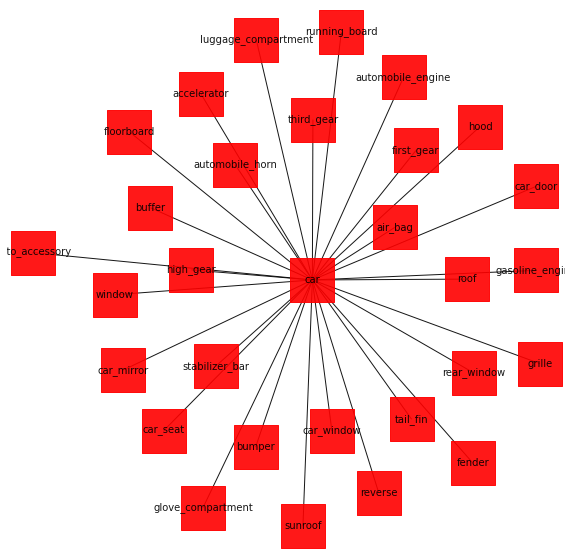

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')


Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [ ]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]
cat = wn.synsets('cat')[0]
dog = wn.synsets('dog')[0]

In [ ]:
bike.path_similarity(cat)

0.05555555555555555

Есть и другие метрики:

In [ ]:
wn.lch_similarity(bike, cat)

0.7472144018302211

In [ ]:
wn.wup_similarity(bike, cat)

0.32

### Домашнее задание. Реализовать алгоритм Леска и проверить его на реальном датасете

Ворднет можно использовать для дизамбигуации. Самый простой алгоритм дизамбигуации - алгоритм Леска. В нём нужное значение слова находится через пересечение слов контекста, в котором употреблено это слово, с определениями значений слова из ворднета. Значение с максимальным пересечением - нужное.

Реализуйте его

In [ ]:
'''Отделение контекста для рассматриваемого слова — не более 10 ближайших по расположению слов.
Поиск всех определений в словаре (любом другом подобном источнике знаний) для рассматриваемого слова.
Поиск слов из контекста в каждом найденном определении.
Если какое-либо слово из контекста присутствует в определении, тогда этому определению дается балл 
(повышается процент верности определения для данного контекста).
В качестве наиболее вероятного значения выбирается то, для которого такое пересечение оказалось больше.'''
def lesk( word, sentence ):
    """Ваш код тут"""
    bestsense = 0
    maxoverlap = 0
    #ваш код
    # в этот словарь будем собирать все значения слова с их баллами
    definitions = {}
    # Поиск всех определений в словаре для рассматриваемого слова.
    synsets = wn.synsets(word)
    for i, syns in enumerate(synsets):
      # Это переменная для счета баллов определения
      accuracy = 0
      # Если какое-либо слово из контекста присутствует в определении, тогда этому определению дается балл 
      for word in sentence:
        if word in syns.definition():
          accuracy += 1
      # добавляем в словарь определение и его баллы в качестве значения
      definitions[syns.definition()] = accuracy
    # находим определение с максимальным баллом с помощью max и пишем в переменную maxoverlap
    maxoverlap = max(definitions.values())
    # определения с баллами у нас были пронумерованы, теперь можно найти и вернуть индекс того определения, у которого значение совпадает с maxoverlap
    for i,item in enumerate(definitions.items()):
      if maxoverlap == item[1]:
        # этот результат мы записываем в переменную bestsense и возвращаем bestsense. Профит.
        bestsense = i
    return bestsense 

Работать функция должна как-то так:

In [ ]:
# на вход подается элемент результата работы уже написанной вами функции get_words_in_context
lesk('day', 'some point or period in time'.split()) # для примера контекст совпадает с одним из определений
# а на выходе индекс подходящего синсета

1

In [ ]:
# с помощью этого индекса достаем нужный синсет
wn.synsets('day')[1].definition()

'some point or period in time'

**Проверьте насколько хорошо работает такой метод на реальном датасете.** http://lcl.uniroma1.it/wsdeval/ - большой фреймворк для оценки WSD. Там много данных и я взял кусочек, чтобы не было проблем с памятью

In [ ]:
corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

Корпус состоит из предложений, где у каждого слова три поля - значение, лемма и само слово. Значение пустое, когда слово однозначное, а у многозначных слов стоит тэг вида **'long%3:00:02::'** Это тэг wordnet'ного формата

In [ ]:
corpus_wsd[1]

[['', 'have', 'Have'],
 ['', 'you', 'you'],
 ['permit%2:41:00::', 'permit', 'permitted'],
 ['', 'it', 'it'],
 ['', 'to', 'to'],
 ['become%2:42:01::', 'become', 'become'],
 ['', 'a', 'a'],
 ['giveaway%1:21:00::', 'giveaway', 'giveaway'],
 ['program%1:09:01::', 'program', 'program'],
 ['rather%4:02:02::', 'rather', 'rather'],
 ['', 'than', 'than'],
 ['', 'one', 'one'],
 ['', 'that', 'that'],
 ['have%2:42:00::', 'have', 'has'],
 ['', 'the', 'the'],
 ['goal%1:09:00::', 'goal', 'goal'],
 ['', 'of', 'of'],
 ['improved%3:00:00::', 'improved', 'improved'],
 ['employee%1:18:00::', 'employee', 'employee'],
 ['morale%1:26:00::', 'morale', 'morale'],
 ['', 'and', 'and'],
 ['', ',', ','],
 ['consequently%4:02:00::', 'consequently', 'consequently'],
 ['', ',', ','],
 ['increased%3:00:00::', 'increased', 'increased'],
 ['productivity%1:07:00::', 'productivity', 'productivity'],
 ['', '?', '?']]

In [56]:
context = ''
for word in corpus_wsd[1]:
  context += word[1] + ' '
print(context)

have you permit it to become a giveaway program rather than one that have the goal of improved employee morale and , consequently , increased productivity ? 


Вот так можно достать соответствующий этому тэгу синсет:

In [ ]:
wn.lemma_from_key('long%3:00:02::').synset()

Synset('long.a.01')

Когда с помощью алгоритма Леска вы найдете подходящее значение, их можно просто сравнить

In [ ]:
wn.synsets('long')

[Synset('hanker.v.01'),
 Synset('long.a.01'),
 Synset('long.a.02'),
 Synset('long.s.03'),
 Synset('retentive.a.01'),
 Synset('long.a.05'),
 Synset('long.a.06'),
 Synset('long.s.07'),
 Synset('farseeing.s.02'),
 Synset('long.s.09'),
 Synset('long.r.01'),
 Synset('long.r.02')]

In [62]:
'''нужно пройтись циклом по всем предложениям в corpus_wsd и в каждом предложении для многозначных слов предсказать значение
То есть на вместо Лонг будет какое-то другое слово каждый раз а контекстом слова вокруг него
тут же я считаю процент правильных предсказаний'''
words_and_definitions = []
accuracy = 0
total = 0
# пройтись циклом по всем предложениям в corpus_wsd
for sentence in corpus_wsd[:1000]:
  lesk_context = ''
  for word in sentence:
    lesk_context += word[1] + ' '
  #print(lesk_context)
  # в каждом предложении находим многозначные слова
  for word in sentence:
    # это слова, у которых на первом месте есть тег
    if word[0] != '':
      lemma_from_key = wn.lemma_from_key(word[0]).synset()
      # предсказываем значение с помощью метода Леска
      # запихиваем в него само слово в виде строки и контекст
      lesk_word = word[1]
      lesk_result = lesk(lesk_word, lesk_context.split())
      total += 1
      # достаем предсказанное значение по индексу, который выдал Леск
      # в синсете мы храним то, что надо сравнить с резулЗдравствуйте. У меня остался только один вопрос по репрезентации того, что получается. Метод я сделала и циклом прошлась, значения у меня какие то нашлись и я их сохранила(у меня есть список кортежей вида (слово, его предсказанное значение)). Теперь, я правильно понимаю, что надо проверить совпадают ли значения, которые я предсказала методом Леска со значениями, которые получаются при вызове вот этой функции wn.lemma_from_key('long%3:00:02::').synset() ? Как их лучше вывести? ьтатом функции wn.lemma_from_key
      synset = wn.synsets(lesk_word)[lesk_result]
      # а тут мы храним само значение
      definition = synset.definition()
      if synset == lemma_from_key:
        accuracy += 1
      result = (lesk_word,definition)
      words_and_definitions.append(result)
statistics = (accuracy/total) * 100
print(statistics,'this is the % of correct predictions')      
print(words_and_definitions[:10])
# тут подходит второй синсет (!в вашем решении вместо индекса единицы будет результат работы функции lesk)
#wn.synsets('long')[1] == wn.lemma_from_key('long%3:00:02::').synset()

28.690036900369005 this is the % of correct predictions
[('long', 'having or being more than normal or necessary:"long on brains"'), ('be', 'have the quality of being; (copula, used with an adjective or a predicate noun)'), ('review', '(accounting) a service (less exhaustive than an audit) that provides some assurance to interested parties as to the reliability of financial data'), ('objective', 'serving as or indicating the object of a verb or of certain prepositions and used for certain other purposes'), ('benefit', 'derive a benefit from'), ('service', '(law) the acts performed by an English feudal tenant for the benefit of his lord which formed the consideration for the property granted to him'), ('program', 'a document stating the aims and principles of a political party'), ('permit', 'allow the presence of or allow (an activity) without opposing or prohibiting'), ('become', 'enhance the appearance of'), ('giveaway', 'a gift of public land or resources for the private gain of a li

In [ ]:
# можно сравнить со всеми, чтобы убедиться
[(syns, wn.synsets('long')[i] == wn.lemma_from_key('long%3:00:02::').synset()) 
  for i, syns in enumerate(wn.synsets('long'))]

[(Synset('hanker.v.01'), False),
 (Synset('long.a.01'), True),
 (Synset('long.a.02'), False),
 (Synset('long.s.03'), False),
 (Synset('retentive.a.01'), False),
 (Synset('long.a.05'), False),
 (Synset('long.a.06'), False),
 (Synset('long.s.07'), False),
 (Synset('farseeing.s.02'), False),
 (Synset('long.s.09'), False),
 (Synset('long.r.01'), False),
 (Synset('long.r.02'), False)]

**Вам нужно для каждого многозначного слова (т.е. у него есть тэг в первом поле) с помощью алгоритма Леска предсказать нужный синсет и сравнить с правильным. Посчитайте процент правильных предсказаний (accuracy).**

Если считается слишком долго, возьмите поменьше предложений (например, только тысячу)

### Дополнительный балл

Если хотите заработать дополнительный балл, попробуйте улучшить алгоритм Леска любым способом (например, использовать расстояние редактирования вместо пересечения или даже вставить машинное обучение)